# Imports

In [125]:
# imports
import pandas as pd
from plotnine import *
from collections import deque
import glob
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.stats import zscore
import time

3. (20 pts) The double-edge swap can also be used to insert a speciﬁc amount of randomness into a network. In this way, we can use it to deﬁne a parametric network model that contains a speciﬁed amount of “real” structure, which we can get from an empirical network. Let $r$ be the number of double-edge swaps we have applied to some input graph $G$.

Using the UC Berkeley social network from the FB100 data set, design and carry out a numerical experiment to answer the following question: as a function of $r$, how does the clustering coeﬃcient $C$ and mean path length $\langle \ell \rangle$ relax onto those of the corresponding conﬁguration model? As references, overlay in your plots horizontal lines for the $C$ and $\langle \ell \rangle$ when you have applied $r = 20m$ swaps (which will be the values expected under the conﬁguration model). Comment on how “random” Berkeley’s social network was to begin with, in what ways, and
on the rate at which randomization destroys the empirical patterns.

In [127]:
# Load the Berkeley social network
uc_berkeley_filepath = "../hw1/facebook100txt/Berkeley13.txt"


def read_graph(filepath):
    """Reads the UC Berkeley social network from FB100 dataset."""
    G = nx.read_edgelist(filepath, nodetype=int, comments='id')
    return G


berkeley_graph = read_graph(uc_berkeley_filepath)

# print(
#     f"Nodes: {berkeley_graph.number_of_nodes()}, Edges: {berkeley_graph.number_of_edges()}"
# )

In [133]:
import pandas as pd
import networkx as nx
from collections import deque
from itertools import combinations


def create_adjacency_dict(edgelist):
    """Creates an adjacency dictionary from an edgelist DataFrame."""
    adj_dict = {}
    for _, row in edgelist.iterrows():
        source, target = row["source"], row["target"]
        # Add both directions since it's an undirected graph
        if source not in adj_dict:
            adj_dict[source] = set()
        if target not in adj_dict:
            adj_dict[target] = set()
        adj_dict[source].add(target)
        adj_dict[target].add(source)
    return adj_dict


def bfs(adj_dict, start_node):
    """
    Performs BFS and returns both visited nodes and distances.
    """
    distances = {start_node: 0}
    visited = set([start_node])
    queue = deque([start_node])

    while queue:
        node = queue.popleft()
        for neighbor in adj_dict.get(node, []):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                distances[neighbor] = distances[node] + 1

    return visited, distances


def calculate_clustering_coefficient(edgelist):
    """
    Calculates the clustering coefficient using the edgelist.
    """
    adj_dict = create_adjacency_dict(edgelist)

    total_coefficient = 0
    node_count = 0

    for node in adj_dict:
        neighbors = adj_dict[node]
        if len(neighbors) < 2:  # Skip nodes with less than 2 neighbors
            continue

        possible_triangles = len(neighbors) * (len(neighbors) - 1) / 2
        actual_triangles = 0

        # Count actual triangles
        for n1, n2 in combinations(neighbors, 2):
            if n2 in adj_dict.get(n1, set()):
                actual_triangles += 1

        if possible_triangles > 0:
            node_coefficient = actual_triangles / possible_triangles
            total_coefficient += node_coefficient
            node_count += 1

    return total_coefficient / node_count if node_count > 0 else 0


def calculate_average_path_length(edgelist):
    """
    Calculates average path length in the largest connected component.
    """
    adj_dict = create_adjacency_dict(edgelist)

    # Find the largest connected component
    unvisited = set(adj_dict.keys())
    largest_component = set()

    while unvisited:
        start = next(iter(unvisited))
        component, _ = bfs(adj_dict, start)
        unvisited -= component
        if len(component) > len(largest_component):
            largest_component = component

    # Calculate average path length in largest component
    total_path_length = 0
    path_count = 0

    for node in largest_component:
        _, distances = bfs(adj_dict, node)
        # Only consider paths within the largest component
        component_distances = {
            k: v for k, v in distances.items() if k in largest_component
        }
        total_path_length += sum(component_distances.values())
        path_count += len(component_distances) - 1  # Subtract 1 to exclude path to self

    return total_path_length / path_count if path_count > 0 else 0


# Convert graph to edgelist and calculate metrics
berkeley_edgelist = nx.to_pandas_edgelist(berkeley_graph)

# Calculate initial metrics
initial_clustering = calculate_clustering_coefficient(berkeley_edgelist)
initial_path_length = calculate_average_path_length(berkeley_edgelist)

print(f"Initial clustering coefficient: {initial_clustering:.4f}")
print(f"Initial average path length: {initial_path_length:.4f}")

KeyboardInterrupt: 

Starting analysis...
Computing initial metrics...
Computing reference values...
Analyzing network evolution...


Analyzing network evolution: 100%|██████████| 10/10 [10:52<00:00, 65.28s/it]


Creating plots...

Total analysis time: 857.35 seconds

Network Analysis Results:
Initial clustering coefficient: 0.2070
Configuration model clustering: 0.0160
Initial average path length: 2.9260
Configuration model path length: 2.7195


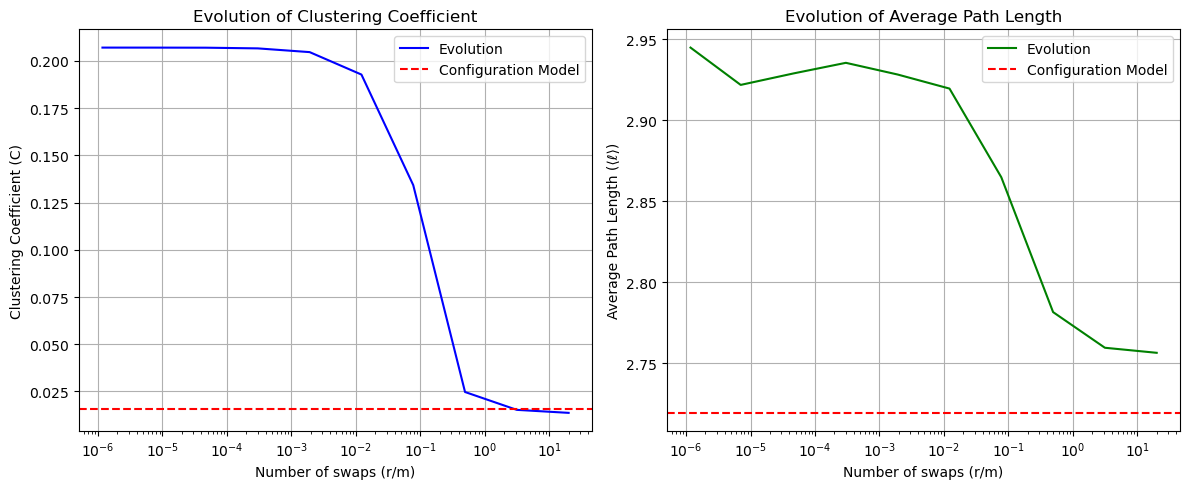

In [16]:
def fast_average_path_length(G):
    """
    Estimates average path length using sampling for large networks.
    """
    n = G.number_of_nodes()
    # If network is small, use exact calculation
    if n < 1000:
        largest_cc = max(nx.connected_components(G), key=len)
        G_cc = G.subgraph(largest_cc)
        return nx.average_shortest_path_length(G_cc)

    # For large networks, use sampling
    sample_size = min(500, n)
    nodes = list(G.nodes())
    sampled_nodes = random.sample(nodes, sample_size)

    total_path_length = 0
    num_paths = 0

    for source in sampled_nodes:
        lengths = nx.single_source_shortest_path_length(G, source)
        total_path_length += sum(lengths.values())
        num_paths += len(lengths)

    return total_path_length / num_paths


def perform_random_edge_swaps(G, num_swaps, seed=None):
    """
    Optimized version of random edge swaps.
    """
    if seed is not None:
        random.seed(seed)

    G_swap = G.copy()
    edges = list(G_swap.edges())
    m = len(edges)

    successful_swaps = 0
    attempts = 0
    max_attempts = num_swaps * 10  # Limit total attempts

    while successful_swaps < num_swaps and attempts < max_attempts:
        # Select edges in batches for efficiency
        idx1, idx2 = random.sample(range(m), 2)
        u1, v1 = edges[idx1]
        u2, v2 = edges[idx2]

        # Quick check for valid swap
        if (
            u1 != u2
            and u1 != v2
            and v1 != u2
            and v1 != v2
            and not G_swap.has_edge(u1, v2)
            and not G_swap.has_edge(u2, v1)
        ):
            # Perform swap
            G_swap.remove_edge(u1, v1)
            G_swap.remove_edge(u2, v2)
            G_swap.add_edge(u1, v2)
            G_swap.add_edge(u2, v1)
            # Update edges list
            edges[idx1] = (u1, v2)
            edges[idx2] = (u2, v1)
            successful_swaps += 1

        attempts += 1

    return G_swap


def analyze_network_evolution(G, max_swaps, num_points=10):
    """
    Analyzes network evolution with fewer sampling points and optimized metrics.
    """
    m = G.number_of_edges()
    # Use fewer points for faster analysis
    swap_points = np.geomspace(1, max_swaps, num_points, dtype=int)

    metrics = {"swaps": [], "clustering": [], "path_length": [], "time": []}

    G_current = G.copy()
    last_swaps = 0

    for swaps in tqdm(swap_points, desc="Analyzing network evolution"):
        start_time = time.time()

        # Perform additional swaps
        if swaps > last_swaps:
            G_current = perform_random_edge_swaps(G_current, swaps - last_swaps)
            last_swaps = swaps

        # Calculate metrics
        metrics["swaps"].append(swaps)
        metrics["clustering"].append(nx.average_clustering(G_current))
        metrics["path_length"].append(fast_average_path_length(G_current))
        metrics["time"].append(time.time() - start_time)

    return metrics


def plot_results(metrics, reference_C, reference_L, m):
    """
    Creates plots of the results.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    x = np.array(metrics["swaps"]) / m

    # Plot clustering coefficient
    ax1.semilogx(x, metrics["clustering"], "b-", label="Evolution")
    ax1.axhline(y=reference_C, color="r", linestyle="--", label="Configuration Model")
    ax1.set_xlabel("Number of swaps (r/m)")
    ax1.set_ylabel("Clustering Coefficient (C)")
    ax1.set_title("Evolution of Clustering Coefficient")
    ax1.legend()
    ax1.grid(True)

    # Plot average path length
    ax2.semilogx(x, metrics["path_length"], "g-", label="Evolution")
    ax2.axhline(y=reference_L, color="r", linestyle="--", label="Configuration Model")
    ax2.set_xlabel("Number of swaps (r/m)")
    ax2.set_ylabel("Average Path Length (⟨ℓ⟩)")
    ax2.set_title("Evolution of Average Path Length")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig


# Main analysis function
def analyze_berkeley_network(berkeley_graph, max_swaps_factor=20):
    """
    Main analysis function with performance monitoring.
    """
    print("Starting analysis...")
    start_time = time.time()

    # Get initial metrics
    print("Computing initial metrics...")
    initial_C = nx.average_clustering(berkeley_graph)
    initial_L = fast_average_path_length(berkeley_graph)

    m = berkeley_graph.number_of_edges()
    max_swaps = max_swaps_factor * m

    # Get reference values
    print("Computing reference values...")
    G_config = perform_random_edge_swaps(berkeley_graph, max_swaps)
    reference_C = nx.average_clustering(G_config)
    reference_L = fast_average_path_length(G_config)

    # Analyze evolution
    print("Analyzing network evolution...")
    metrics = analyze_network_evolution(berkeley_graph, max_swaps)

    # Create plots
    print("Creating plots...")
    fig = plot_results(metrics, reference_C, reference_L, m)

    total_time = time.time() - start_time
    print(f"\nTotal analysis time: {total_time:.2f} seconds")

    return {
        "initial_C": initial_C,
        "initial_L": initial_L,
        "reference_C": reference_C,
        "reference_L": reference_L,
        "metrics": metrics,
        "total_time": total_time,
    }


# Run the analysis
results = analyze_berkeley_network(berkeley_graph)

# Print summary statistics
print("\nNetwork Analysis Results:")
print(f"Initial clustering coefficient: {results['initial_C']:.4f}")
print(f"Configuration model clustering: {results['reference_C']:.4f}")
print(f"Initial average path length: {results['initial_L']:.4f}")
print(f"Configuration model path length: {results['reference_L']:.4f}")

4. (30 pts) In network data science, the conﬁguration model serves as the key null model for deciding whether some network measure x = f (G) is big or small or typical or unusual. Visit the Index of Complex Networks (ICON) at icon.colorado.edu and obtain your choice of

- 1 online / social network
- 1 food web / biological network, and
- 1 connectome / biological network.

Treating them as simple graphs, design and carry out a numerical experiment to answer the following question for each network: to what degree can the network’s (i) clustering coeﬃcient $C$ and (ii) mean path length $\langle \ell \rangle$ be explained by its degree structure? Display your results using plots showing the null distributions of these statistics under the conﬁguration model, and overlay on that distribution a vertical line showing the empirical value for that network. Discuss (i) whether the empirical values are big, small, typical, or unusual, (ii) what that
conclusion implies about the structure of these networks, and (iii) what hypotheses it suggests about the underlying data generating process that produced these networks.

Hint: A good null distribution requires around 1000 conﬁguration model random graphs.
Applying a double-edge swap operation $r = 20m$ times, starting with the empirical graph
at $r = 0$, is suﬃcient to generate a single corresponding conﬁguration model random graph. The bigger the graphs you choose, the longer your compute times will be.

In [66]:
# social_networks_folder = "files/hp/"
zebra_filepath = "files/moreno_zebra/out.moreno_zebra_zebra"
food_web_filepath = "files/fw/out.maayan-foodweb"
connectome_filepath = "files/con/rhesus_brain_2.graphml"


In [86]:
def read_out_network_data(filepath, type = 'directed'):
    """
    Reads network data from edge list files, handling comment lines.

    Parameters:
    filepath (str): Path to the network data file

    Returns:
    networkx.Graph: An undirected NetworkX graph object
    """
    try:
        if type == 'directed':
            # Create a directed graph
            G = nx.DiGraph()
        else:
        # Create an undirected graph
            G = nx.Graph()

        # Read edges, skipping comment lines
        with open(filepath, "r") as f:
            for line in f:
                # Skip comment lines starting with %
                if line.startswith("%"):
                    continue

                # Split line into source and target nodes
                parts = line.strip().split()
                if len(parts) >= 2:  # Ensure we have at least source and target
                    source, target = map(int, parts[:2])
                    G.add_edge(source, target)

        return G

    except Exception as e:
        print(f"Error reading network file: {str(e)}")
        print(f"Make sure the file exists at: {filepath}")
        return None


connectome = nx.read_graphml(connectome_filepath)
food_web = read_out_network_data(food_web_filepath, type = 'directed')
zebra_web = read_out_network_data(zebra_filepath, type = 'undirected')

# plot the zebra network
# nx.draw(zebra_web, with_labels=True)
# plt.show()

In [87]:
def determine_largest_connected_component(G):
    """
    Determines the largest connected component of a network.

    Parameters:
    G (networkx.Graph): A NetworkX graph object

    Returns:
    networkx.Graph: The largest connected component
    """
    if G.is_directed():
        largest_cc = max(nx.strongly_connected_components(G), key=len)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc).copy()


connectome_lcc = determine_largest_connected_component(connectome)
food_web_lcc = determine_largest_connected_component(food_web)
zebra_web_lcc = determine_largest_connected_component(zebra_web)

# print("\nLargest Connected Components:")
# print(f"Connectome: {connectome_lcc.number_of_nodes()} nodes, {connectome_lcc.number_of_edges()} edges")
# print(f"Food Web: {food_web_lcc.number_of_nodes()} nodes, {food_web_lcc.number_of_edges()} edges")
# print(f"Zebra Web: {zebra_web_lcc.number_of_nodes()} nodes, {zebra_web_lcc.number_of_edges()} edges")


In [88]:
def compute_C_and_L(G):
    """Computes the clustering coefficient and average shortest path length of a graph."""
    clustering_coeff = nx.average_clustering(G)

    # Check if the graph is directed
    if G.is_directed():
        if nx.is_strongly_connected(
            G
        ):  # For directed graphs, check strong connectivity
            path_length = nx.average_shortest_path_length(G)
        else:
            print("Graph is not strongly connected.")
            path_length = None  # Handle disconnected directed graphs
    else:
        if nx.is_connected(G):  # For undirected graphs
            path_length = nx.average_shortest_path_length(G)
        else:
            print("Graph is not connected.")
            path_length = None  # Handle disconnected undirected graphs

    return clustering_coeff, path_length


connectome_C, connectome_L = compute_C_and_L(connectome_lcc)
food_web_C, food_web_L = compute_C_and_L(food_web_lcc)
zebra_web_C, zebra_web_L = compute_C_and_L(zebra_web_lcc)

print("\nNetwork Analysis Results:")
print(f"Connectome: C={connectome_C:.4f}, L={connectome_L:.4f}")
print(f"Food Web: C={food_web_C:.4f}, L={food_web_L:.4f}")
print(f"Zebra Web: C={zebra_web_C:.4f}, L={zebra_web_L:.4f}")


Network Analysis Results:
Connectome: C=0.9100, L=1.1000
Food Web: C=0.3865, L=2.2597
Zebra Web: C=0.8543, L=1.8617


In [89]:
def generate_configuration_model(G, num_samples=1000):
    """Generates a null distribution for clustering coefficient and path length using the configuration model"""
    degrees = [d for n, d in G.degree()]
    clustering_coeffs = []
    path_lengths = []

    for _ in range(num_samples):
        # Generate a configuration model graph
        random_G = nx.configuration_model(degrees)
        # Convert to simple graph (removes self-loops and parallel edges)
        random_G = nx.Graph(random_G)
        random_G.remove_edges_from(nx.selfloop_edges(random_G))

        # Compute metrics
        C = nx.average_clustering(random_G)
        clustering_coeffs.append(C)

        if nx.is_connected(random_G):
            L = nx.average_shortest_path_length(random_G)
            path_lengths.append(L)

    return np.array(clustering_coeffs), np.array(path_lengths)

connectome_C_null, connectome_L_null = generate_configuration_model(connectome_lcc)
food_C_null, food_L_null = generate_configuration_model(food_web_lcc)
zebra_C_null, zebra_L_null = generate_configuration_model(zebra_web_lcc)

In [117]:
def plot_null_distribution(null_values, empirical_value, title, xlabel):
    """Plots the null distribution with an empirical value marker and legend."""

    # Create DataFrames for null distribution and empirical value
    df_null = pd.DataFrame({xlabel: null_values, "type": "Null Distribution"})
    df_empirical = pd.DataFrame({xlabel: [empirical_value], "type": "Empirical Value"})

    # Combine data for plotting
    df = pd.concat(
        [
            df_null, 
            # df_empirical
        ]
    )

    # Create the plot
    plot = (
        ggplot(df, aes(x=xlabel))
        + geom_histogram(
            aes(y="..density..", fill="type"), bins=30, alpha=0.6, color="black"
        )  # Histogram with fill mapped to 'type'
        + geom_density(aes(color="type"), size=1, linetype = 'dashed')  # Density curve mapped to 'type'
        + geom_vline(
            aes(xintercept=xlabel, color="type"),
            data=df_empirical,
            linetype="dashed",
            size=1,
        )  # Ensure empirical value appears in legend
        + theme_minimal()
        + labs(title=title, x=xlabel, y="Density", fill="Legend", color="Legend")
        + scale_fill_manual(
            values={"Null Distribution": "skyblue", "Empirical Value": "red"}
        )
        + scale_color_manual(
            values={"Null Distribution": "blue", "Empirical Value": "red"}
        )
    )

    return plot

# Recreate plots with improved aesthetics
plot_null_distribution(
    food_C_null, food_web_C, "Food Web Clustering Coefficient", "Clustering Coefficient"
).save("figures/food_clustering.png")
plot_null_distribution(food_L_null, food_web_L, "Food Web Path Length", "Path Length").save("figures/food_path.png")

plot_null_distribution(
    connectome_C_null,
    connectome_C,
    "Connectome Clustering Coefficient",
    "Clustering Coefficient",
).save("figures/connectome_clustering.png")
plot_null_distribution(
    connectome_L_null, connectome_L, "Connectome Path Length", "Path Length"
).save("figures/connectome_path.png")

plot_null_distribution(
    zebra_C_null,
    zebra_web_C,
    "Zebra Web Clustering Coefficient",
    "Clustering Coefficient",
).save("figures/zebra_clustering.png")

plot_null_distribution(
    zebra_L_null, zebra_web_L, "Zebra Web Path Length", "Path Length"
).save("figures/zebra_path.png")

/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/food_clustering.png
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/food_path.png
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/connectome_clustering.png
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/envs/networks/lib/python3.12/site-packages/plotnine/ggplot.py:616: Plo

5. (20 pts) Null models can also be used to test hypotheses about individual nodes and their positions within the network. For example, is a high centrality value for node i actually just a function of the network’s degree structure? Here, we use this approach to revisit a classic paper in social network analysis.

The Medici family was a powerful political dynasty and banking family in 15th century Florence. The classic network explanation of their power2 argues that their inﬂuence came from positioning themselves as the most central node within the network of prominent Florentine families (see the network figure below). Visit the Index of Complex Networks and obtain a copy of the Medici network data file, under the “Padgett Florentine families” ICON entry. Conduct the following tests of the Medici structural importance hypothesis. Define the harmonic centrality of a node as

$$
C_{i} = \frac{1}{n-1}\sum_{j=1 ; j \neq i}^{n}\frac{1}{\ell_{ij}}    
$$

where $\ell_{ij}$ is the length of the shortest path from node $i$ to node $j$; if there is no such path, i.e., because $i$ and $j$ are in different components, then we define $\ell_{ij} = \inf$.

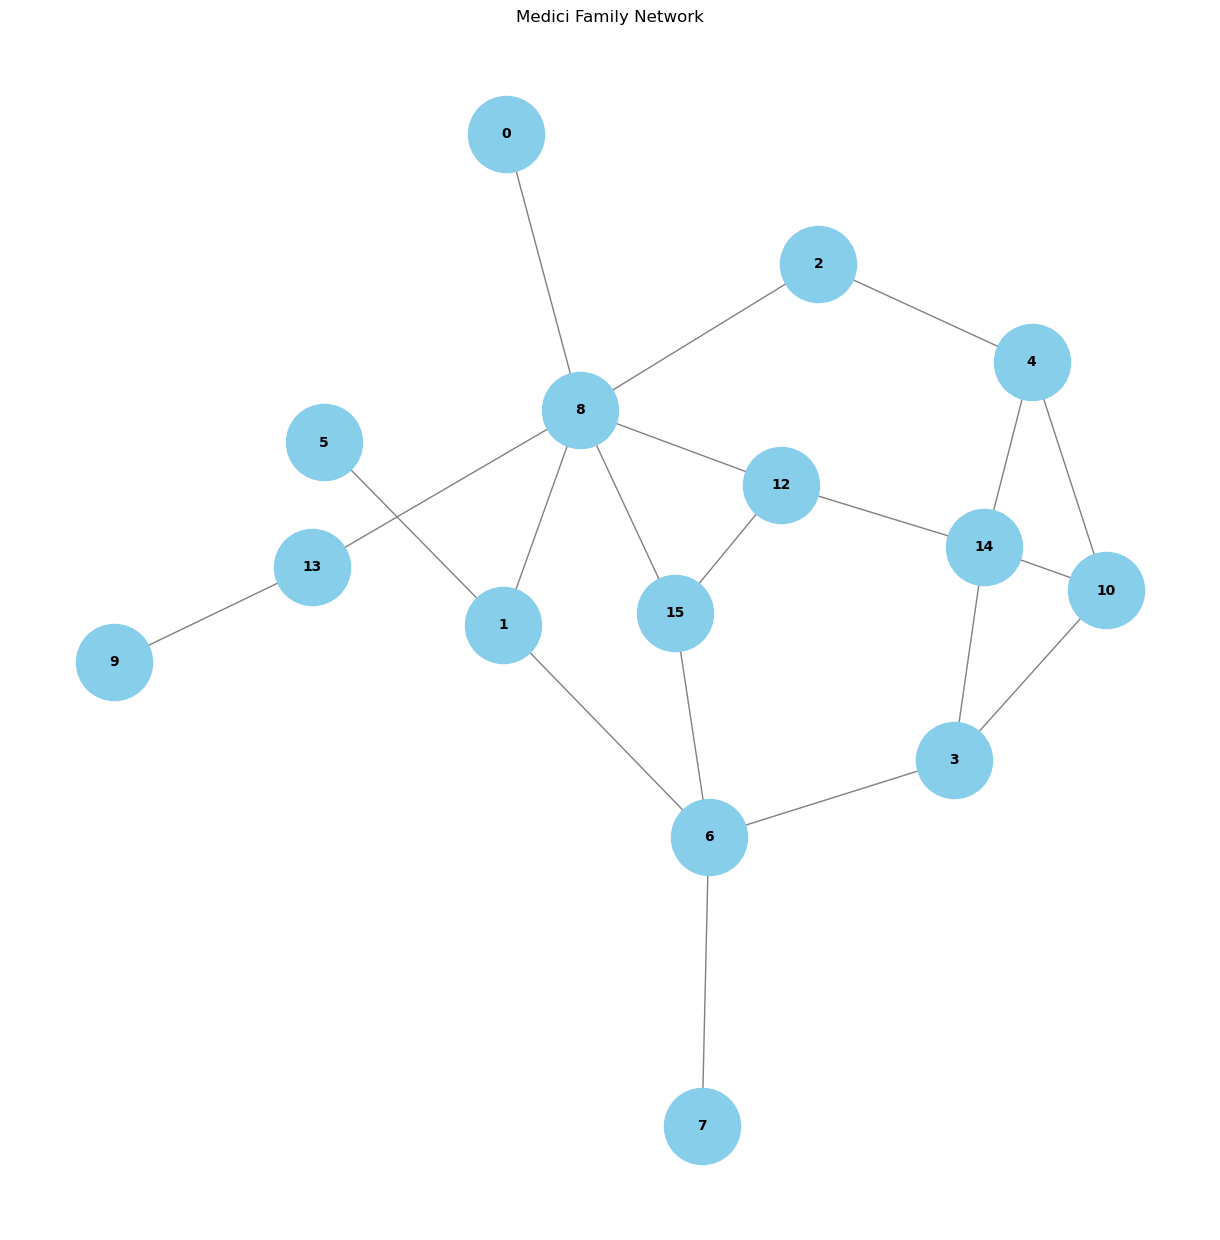

In [124]:
import networkx as nx
import matplotlib.pyplot as plt
import re


def read_medici_network(filepath):
    """
    Reads the Medici family network from a text file in adjacency list format.

    Parameters:
    filepath (str): Path to the Medici family network file

    Returns:
    networkx.Graph: A NetworkX graph object
    """
    G = nx.Graph()

    with open(filepath, "r") as f:
        for line in f:
            # Regex to match the format: family_id family_name, family_id num_connections [ (connected_family, weight) ]
            match = re.match(r"(\d+)\s([^,]+),\s(\d+)\s(\d+)\s\[(.*)\]", line.strip())
            if match:
                family_id = int(match.group(1))
                family_name = match.group(2)
                num_connections = int(match.group(3))
                connections = match.group(5).strip()

                # Extract connected families and weights
                edges = []
                if connections:
                    for conn in connections.split(")"):
                        if (
                            conn.strip()
                        ):  # Check if the connection is not an empty string
                            pair = conn.strip(" (").split(", ")
                            connected_family, weight = int(pair[0]), int(pair[1])
                            edges.append((family_id, connected_family, weight))

                # Add edges to the graph
                for edge in edges:
                    G.add_edge(edge[0], edge[1], weight=edge[2])

    return G


# Path to your Medici network data file
medici_filepath = "files/Medici network/medici_network.txt"
medici_network = read_medici_network(medici_filepath)

# # Visualizing the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(medici_network, seed=42)  # Layout the nodes

# Draw the nodes, edges, and labels
nx.draw(
    medici_network,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="skyblue",
    font_size=10,
    font_weight="bold",
    edge_color="gray",
)
plt.title("Medici Family Network")
plt.show()

(a) Calculate and report the harmonic centrality of each node in the Medici network, and
comment on where in the corresponding ranking the Medici family appears. Then discuss
the degree to which your findings agree with the network explanation of the Medici’s
power, and what the scores say about how important is second most important family.

In [123]:
def calculate_harmonic_centrality(G):
    """
    Calculates the harmonic centrality of nodes in a graph.

    Parameters:
    G (networkx.Graph): A NetworkX graph object

    Returns:
    dict: A dictionary of harmonic centrality values for each node
    """
    # Initialize the dictionary to store harmonic centrality values
    harmonic_centrality = {}

    # Iterate over each node in the graph
    for node in G.nodes():
        # Compute the harmonic centrality of the node
        harmonic_centrality[node] = sum(
            1 / len(path) for path in nx.single_source_shortest_path(G, node).values()
        )

    return harmonic_centrality

medici_harmonic_centrality = calculate_harmonic_centrality(medici_network)
print("\nHarmonic Centrality:")
for node, centrality in medici_harmonic_centrality.items():
    print(f"Node {node}: {centrality:.4f}")


Harmonic Centrality:
Node 0: 5.0167
Node 8: 6.4167
Node 1: 5.8333
Node 5: 4.7167
Node 6: 5.8667
Node 2: 5.5333
Node 4: 5.3500
Node 3: 5.4833
Node 10: 5.2667
Node 14: 5.7333
Node 7: 4.7167
Node 15: 5.8333
Node 12: 5.9167
Node 13: 5.2667
Node 9: 4.3833


(b) Design and carry out a numerical experiment to answer the question: to what degree can each family’s structural importance be explained as purely a function of the network’s degree sequence $\vec{k}$? Use these results to assess the network explanation of the Medici’s power, and explain how your results answer that question. Comment on which other families are more (or less) important than we expect under the null model.

Hint: If a family’s centrality score is ‘typical’ in the null model, then we conclude that its centrality can be explained entirely by the network’s degree sequence; if it not typical, then we conclude that other factors (beyond degrees) are needed to explain its centrality, e.g., it could be more central than we expect, or less!

Hint: As above, 1000 random graphs should give you a good null distribution, and it
should be sufficient to apply r = 20m double-edge swaps to produce one such graph.
Because you need to look at all the families, a good visualization would arrange the node indices on the x-axis and plot for each the corresponding distribution of $(C_{i}^{null})_{j} - C_{i}^{data}$, where $j$ indexes the random graphs. The degree to which each distribution spans $y = 0$ is then informative.

(c) (10 pts extra credit) Repeat the above experiment but change the null model to one that uses “the wrong” graph space. Specifically, use the stub-matching algorithm to construct stub-labeled loopy multigraphs, which you then “simplify” by removing self-loops and collapsing multiedges. Make the same plot as before, and discuss how your results here differ (if at all) from when you use the correct null model (one that matches the data’s graph space), and what conclusions would change (if any)